## Table of Contents :

<div class="alert alert-block alert-info" style="margin-top: 20px">


* 1. Imports and Auxiliary Functions
* 2. Data Class 
* 3. The experiment class
* 3. Training Resnet 18
* 4. Training Densenet121
* 5. Training Resnet18 + log softmax
* 6. Resnet for feature Extraction + Random Forest
* 7. Majority Vote



 </div>
<hr>

##1. Imports and Auxiliary Functions :

In [ ]:
import torchvision.models as models
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch 
from torchvision import transforms
import torch.nn.functional as F

from PIL import Image

import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from skimage import feature
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v

from tqdm.notebook import tqdm
import itertools
import random
import time
import os
import pickle


seed = 74
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

In [ ]:
#download data
! pip install kaggle # Install the Kaggle library
! mkdir ~/.kaggle # Make a directory named “.kaggle”
! cp /content/kaggle.json ~/.kaggle/ # Copy the “kaggle.json” into this new directory
! chmod 600 ~/.kaggle/kaggle.json # Allocate the required permission for this file.

In [ ]:
!kaggle competitions download "fall2021-inf8245e-machine-learning" # Downloading Competitions dataset

  0% 0.00/23.4k [00:00<?, ?B/s]
100% 23.4k/23.4k [00:00<00:00, 9.31MB/s]
 93% 87.0M/93.3M [00:00<00:00, 117MB/s]
100% 93.3M/93.3M [00:00<00:00, 147MB/s]
 93% 130M/140M [00:01<00:00, 142MB/s]
100% 140M/140M [00:01<00:00, 129MB/s]
  0% 0.00/60.0 [00:00<?, ?B/s]
100% 60.0/60.0 [00:00<00:00, 31.2kB/s]


In [ ]:
!unzip "/content/x_train.pkl.zip"
!unzip "/content/x_test.pkl.zip"

Archive:  /content/x_train.pkl.zip
  inflating: x_train.pkl             
Archive:  /content/x_test.pkl.zip
  inflating: x_test.pkl              


In [ ]:
class_dic = { "big_cats":0,  "butterfly":1,  "cat":2,  "chicken":3,  "cow":4, "dog":5,  "elephant":6, "goat":7,  "horse":8,  "spider":9,  "squirrel":10}

## Data Preparation

In [ ]:

class Dataset(Dataset):

    # Constructor
    def __init__(self,params,transform=False):
      if not params['TEST'] :
        with open('y_train.pkl', 'rb') as f:
          self.labels_sting = pickle.load(f)
        

        with open('x_train.pkl', 'rb') as f:
          self.images = pickle.load(f)




        y = np.array(self.labels_sting)
        
        df = pd.DataFrame()
        df['Y']=y
        self.labels = df['Y'].map(class_dic).values

      if  params['TEST']:
        
        with open('x_test.pkl', 'rb') as f:
          self.images = pickle.load(f)
        #self.cropped = np.load('/content/drive/MyDrive/outputs/xt_cropped.npy')
        self.labels = np.zeros(len(self.images))

      self.len = len(self.labels)
      self.image_size = 96
      self.input_size = params['INPUT_SIZE']
      self.transforms = transform
      self.val_test_size = params['VALIDATION_AND_TEST_SET_SIZE'] 
      self.mode = params['MODE'] 


    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, index):
          if self.transforms:
            input =  np.zeros((self.image_size,self.image_size,3))

            if self.mode == "ALL_ORIGINAL" :
                original = self.images[index]
                input[:,:,0] = original
                input[:,:,1] = original
                input[:,:,2] = original

            PIL_input = Image.fromarray(input.astype(np.uint8))
            image = self.transforms(PIL_input)
 
          else :
            image = torch.tensor([self.images[index],self.images[index],self.images[index]]).type(torch.Tensor)
          
          label = torch.tensor(self.labels[index]).type(torch.long)

          return image.view(3,input_size,input_size), label


    def sample(self,index = 0):

      image = self.images[index]
      label = self.labels_sting[index]
      plt.imshow(image, cmap='gray', vmin=0, vmax=1)
      print("label : ",label)
      plt.show()


    def split_data(self):
      val_size = self.val_test_size
      return torch.utils.data.random_split(self,[self.len - 2 *int(self.len*val_size),  int(self.len*val_size),  int(self.len*val_size)])





##2. The Experiment Class

In [ ]:

class Experiment:

    def __init__(self,model=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.use_cuda = torch.cuda.is_available()
        self.model = model.cuda()
        self.optimizer = None
        self.scheduler = None
        

        self.criterion = torch.nn.CrossEntropyLoss().cuda() if self.use_cuda else torch.nn.MSELoss()
        self.train_losses = []
        self.train_accs = []
        self.train_f1_log = []
        self.val_losses = []
        self.val_accs = []
        self.val_f1_log = []
        self.start_epoch = 1

    def train(self,train_data_loader,
              val_data_loader,
              save_dir,
              model_name,
              num_epochs=75, 
              learning_rate=0.001,
              validate_each_epoch=False,
              verbose=False):
       

        self.model.train()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=1e-5)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=1, verbose=True)
        
        best_val_f1 = 0.4

        for epoch in range(self.start_epoch, num_epochs + 1):

            print('Epoch {}/{}'.format(epoch, num_epochs))

            epoch_losses = []
            epoch_accs = []
            epoch_f1 = []
            i = 0
            if verbose :
              pbar = tqdm(train_data_loader)
            else :
              pbar = train_data_loader
            for data in pbar:

                images,labels  = data
                labels = labels.to(self.device)
                images = images.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model.forward(images)

                loss = self.criterion(outputs, labels)
                loss.backward()

                self.optimizer.step()

                epoch_losses.append(loss.data.cpu())
                
                batch_accuracy = accuracy(outputs, labels)

                epoch_accs.append(batch_accuracy) 
                batch_f1 = f1_score_(outputs, labels)
                epoch_f1.append(batch_f1) 

                if verbose:
                  pbar.set_postfix({"Batch loss ":loss.data.cpu().numpy(),' Epoch loss ': np.mean(epoch_losses)," Batch Acc ":batch_accuracy.numpy()," Epoch Acc ":np.mean(epoch_accs),
                                    " Batch f1 ":batch_f1,"  Avg Epoch f1 ":np.mean(epoch_f1)})   

            self.train_losses.append(np.mean(epoch_losses))
            self.train_accs.append(np.mean(epoch_accs))
            self.train_f1_log.append(np.mean(epoch_f1))



            if validate_each_epoch:
                val_loss,val_acc,val_f1= self.validate(val_data_loader)
                self.val_losses.append(val_loss)
                self.val_accs.append(val_acc) 
                self.val_f1_log.append(val_f1) 
                if verbose:  
                  print("Val loss : ",val_loss,' Val Acc : ',val_acc," Val f1 : ",val_f1)   
            
            #Lr scheduler
            self.scheduler.step(np.mean(epoch_losses))


            if val_f1 > best_val_f1 :
              self.save_parameters(model_name+" "+str(val_f1.round(2)), save_dir,epoch)
              best_val_f1 = val_f1




    def validate(self,data_loader):
        
        self.model.eval()
        losses = []
        predictions = []
        y_val = []
        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                labels = labels.to(self.device)
                images = images.to(self.device)

                outputs = self.model.forward(images)
                loss = self.criterion(outputs, labels)
                losses.append(loss.data.cpu())
                _, outputs = torch.max(outputs, dim=1)
                predictions.extend(list(outputs.view(-1).cpu().numpy()))
                y_val.extend(list(labels.view(-1).cpu().numpy()))

        acc = accuracy_score(y_val, predictions)
        f1 = f1_score(y_val, predictions,average='micro')

        self.model.train()
        
        return np.mean(losses),acc,f1




    def predict_loader(self,data_loader):
        self.model.eval()
        predictions = []

        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                images = images.to(self.device)
                outputs = self.model.forward(images)
                _, outputs = torch.max(outputs, dim=1)
                predictions.extend(list(outputs.view(-1).cpu().numpy()))

        self.model.train()
        return predictions
    






    def feature_extraction(self,data_loader):

        self.model.eval()
        predictions = []

        def hook(module, input, output):
          for i in output:
            predictions.append(i.detach().cpu().view(512).numpy())

        self.model.cnn1.avgpool.register_forward_hook(hook)

        with torch.no_grad():
            for data in tqdm(data_loader):                
                images,labels  = data
                images = images.to(self.device)
                outputs = self.model.forward(images)

        self.model.train()
        return predictions





    def save_parameters(self,model_name, directory,epoch):
        """Saves the parameters of the network to the specified directory.

        Parameters
        ----------
        epoch : int
            The current epoch
        directory : str
            The directory to which the parameters will be saved
        """
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, os.path.join(directory, model_name +'.pth'))

    def load_parameters(self, path):
        """Loads the given set of parameters.

        Parameters
        ----------
        path : str
            The file path pointing to the file containing the parameters
        """
        self.optimizer = torch.optim.Adam(self.model.parameters())
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.start_epoch = checkpoint['epoch']

    def plot(self):

      fig, axes = plt.subplots(3, 1, figsize = (10,10))

      train_losses = np.array(self.train_losses)
      val_losses  = np.array(self.val_losses)
      axes[0].plot(train_losses, label = "training loss")
      axes[0].plot(val_losses, label = "val loss")
      axes[0].set_title('loss variation during training', fontsize = 8)
      axes[0].legend()


      train__accs = np.array(self.train_accs)
      val_accs  = np.array(self.val_accs)
      axes[1].plot(train__accs, label = "training accuracy")
      axes[1].plot(val_accs, label = "val accuracy")
      axes[1].set_title('accuracy variation during training', fontsize = 8)
      axes[1].legend()



      train_f1_log = np.array(self.train_f1_log)
      val_f1_log  = np.array(self.val_f1_log)
      axes[2].plot(train_f1_log, label = "training f1 score")
      axes[2].plot(val_f1_log, label = "val f1 score")
      axes[2].set_title('f1 score variation during training', fontsize = 8)
      axes[2].legend()

      plt.show()



      
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


from sklearn.metrics import f1_score,accuracy_score

def f1_score_(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return f1_score(preds.detach().cpu().numpy(), labels.cpu().numpy(), average='micro')

##3. Training the first Resnet18 model :

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = models.resnet18(pretrained=False)
        self.cnn1.fc = nn.Linear(512, 11)
      
    def forward(self, x):
        out =self.cnn1(x)
        return out

model= CNN().cuda() #CNN()
exp_1 = Experiment(model)

for param in exp_1.model.parameters():
    param.requires_grad = True
#model.load_parameters("")
model

CNN(
  (cnn1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

We create three dataset objects, one for the training, one for the validation and on for testing.

In [ ]:
input_size = 224
t = transforms.Compose([transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.RandomRotation(5),
                        transforms.RandomRotation(7),
                        transforms.Resize(input_size),
                        transforms.ToTensor()])


params = {}
params['VALIDATION_AND_TEST_SET_SIZE'] = 0.07
params['INPUT_SIZE'] = input_size
params['TEST'] = False
params['MODE'] = "ALL_ORIGINAL"

dataset =Dataset(params,transform= t)
train_dataset ,val_dataset, test_dataset  = dataset.split_data()

print('train size : ',len(train_dataset))
print('val size : ',len(val_dataset))
print('test size : ',len(test_dataset))

train size :  10699
val size :  594
test size :  594


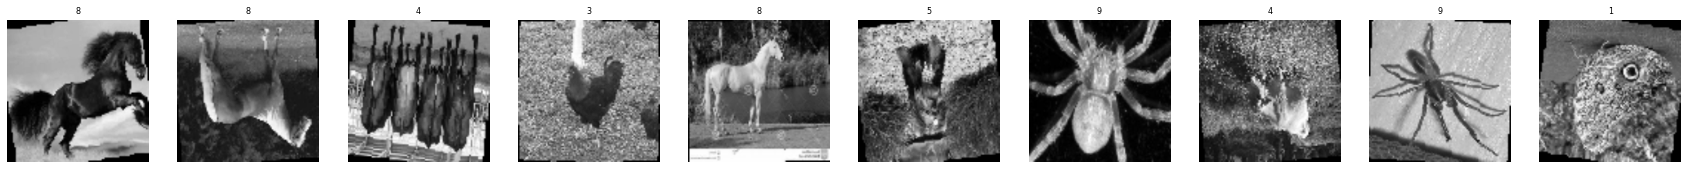

In [ ]:
import matplotlib.pyplot as plt
import random 
W_grid = 10
L_grid = 1

fig, axes = plt.subplots(L_grid, W_grid, figsize = (30,5))


for i in range(W_grid):
  index = random.randint(0,len(dataset) ) 
  image = dataset[index][0].numpy()
  axes[i].imshow(image[0], cmap='gray')

  axes[i].set_title(dataset[index][1].numpy(), fontsize = 8)
  axes[i].axis('off')



In [ ]:

## Creating 
batch_size_train = 32
batch_size_val = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size_val)

In [ ]:
exp_1.train(train_data_loader=train_loader,
                        val_data_loader=validation_loader,
                        save_dir="/content/",
                        model_name = 'model resnet18',
                        num_epochs=100,
                        learning_rate=0.001, 
                        validate_each_epoch=True,
                        verbose=True)


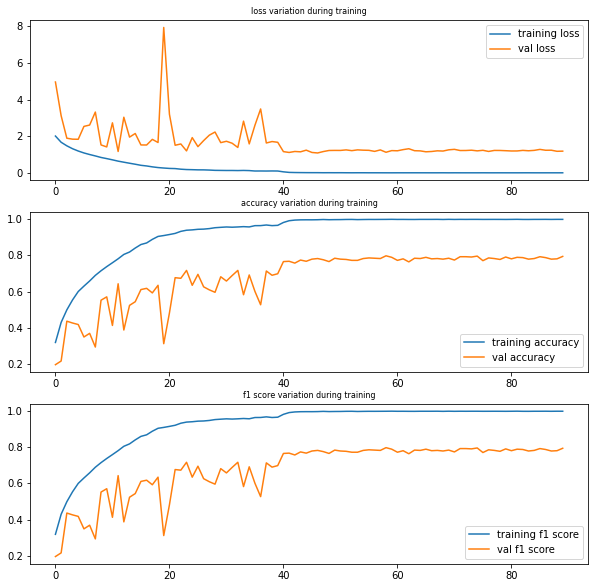

In [ ]:
#exp_1.plot()

In [ ]:
exp_1.load_parameters("/content/model resnet18 0.8.pth")

In [ ]:
exp_1.validate(validation_loader)

  0%|          | 0/19 [00:00<?, ?it/s]

(1.2529615, 0.7895622895622896, 0.7895622895622896)

  0%|          | 0/19 [00:00<?, ?it/s]

f1 score :  0.7727272727272727
              precision    recall  f1-score   support

    big_cats       0.93      0.96      0.94        52
   butterfly       0.73      0.75      0.74        44
         cat       0.74      0.62      0.68        32
     chicken       0.76      0.82      0.79        57
         cow       0.75      0.73      0.74        41
         dog       0.70      0.79      0.74        99
    elephant       0.90      0.69      0.78        26
        goat       0.66      0.57      0.61        47
       horse       0.83      0.73      0.78        62
      spider       0.83      0.85      0.84       103
    squirrel       0.68      0.74      0.71        31

    accuracy                           0.77       594
   macro avg       0.77      0.75      0.76       594
weighted avg       0.77      0.77      0.77       594



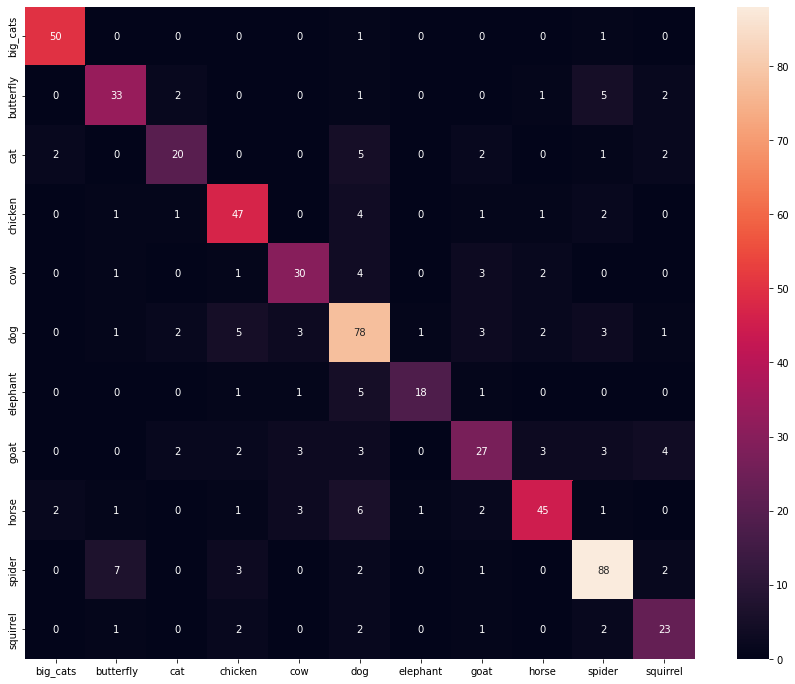

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_val)
y_hat = exp_1.predict_loader(test_loader)
y_true = dataset.labels[test_dataset.indices]
print("f1 score : ",f1_score(y_hat,y_true, average='micro'))
print(classification_report(y_true, y_hat,target_names=list(class_dic.keys())))

M = confusion_matrix(y_true, y_hat)

df_cm = pd.DataFrame(M, index = [i for i in list(class_dic.keys())],
                      columns = [i for i in list(class_dic.keys())])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)

In [ ]:
t = transforms.Compose([transforms.Resize(input_size),transforms.ToTensor()])

params['TEST'] = True
dataset_test =Dataset(params,transform = t)
test_loader_submission = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=128)
y_test_hat = exp_1.predict_loader(test_loader_submission)


sub = pd.DataFrame()
sub['id'] = np.arange(17831)
sub['class'] = y_test_hat
sub.to_csv("RESNET_2_81.csv",index=False)
sub.head(20)

  0%|          | 0/140 [00:00<?, ?it/s]

,id,class
0,0,5
1,1,4
2,2,4
3,3,10
4,4,5
5,5,10
6,6,7
7,7,5
8,8,9
9,9,4


##4. Training the first Densenet181 model :

We create three dataset objects, one for the training, one for the validation and on for testing.

In [ ]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.cnn1 = models.densenet121(pretrained=False)
        self.cnn1.fc = nn.Linear(1024, 11)
      
    def forward(self, x):
        out =self.cnn1(x)
        return out

model2= CNN2().cuda() #CNN()
exp_2 = Experiment(model2)

for param in exp_2.model.parameters():
    param.requires_grad = True
#model.load_parameters("")


In [ ]:
exp_2.train(train_data_loader=train_loader,
                        val_data_loader=validation_loader,
                        save_dir="/content/",
                        model_name = 'model_densenet121_',
                        num_epochs=50,
                        learning_rate=0.001, 
                        validate_each_epoch=True,
                        verbose=True)


Epoch 1/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.55484  Val Acc :  0.48677884615384615  Val f1 :  0.48677884615384615
Epoch 2/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.570125  Val Acc :  0.5168269230769231  Val f1 :  0.5168269230769231
Epoch 3/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.3829253  Val Acc :  0.5384615384615384  Val f1 :  0.5384615384615384
Epoch 4/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.9712131  Val Acc :  0.47115384615384615  Val f1 :  0.47115384615384615
Epoch 5/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  2.895891  Val Acc :  0.3870192307692308  Val f1 :  0.3870192307692308
Epoch 6/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  3.0774636  Val Acc :  0.3870192307692308  Val f1 :  0.3870192307692308
Epoch 7/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  2.7794147  Val Acc :  0.42908653846153844  Val f1 :  0.42908653846153844
Epoch 8/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  2.1792574  Val Acc :  0.4831730769230769  Val f1 :  0.4831730769230769
Epoch 9/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  2.4488137  Val Acc :  0.4338942307692308  Val f1 :  0.4338942307692308
Epoch 10/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.1448138  Val Acc :  0.6430288461538461  Val f1 :  0.6430288461538461
Epoch 11/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.2613161  Val Acc :  0.6237980769230769  Val f1 :  0.6237980769230769
Epoch 12/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.4024893  Val Acc :  0.6165865384615384  Val f1 :  0.6165865384615384
Epoch 13/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.4029542  Val Acc :  0.6141826923076923  Val f1 :  0.6141826923076923
Epoch 14/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.1253388  Val Acc :  0.6646634615384616  Val f1 :  0.6646634615384616
Epoch 15/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.1754762  Val Acc :  0.671875  Val f1 :  0.671875
Epoch 16/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.8178998  Val Acc :  0.5564903846153846  Val f1 :  0.5564903846153846
Epoch 17/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.4437455  Val Acc :  0.6538461538461539  Val f1 :  0.6538461538461539
Epoch 18/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.3311656  Val Acc :  0.6574519230769231  Val f1 :  0.6574519230769231
Epoch 19/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.156936  Val Acc :  0.7019230769230769  Val f1 :  0.7019230769230769
Epoch 20/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.3391967  Val Acc :  0.6634615384615384  Val f1 :  0.6634615384615384
Epoch 21/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.7259837  Val Acc :  0.6370192307692307  Val f1 :  0.6370192307692307
Epoch 22/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.3018507  Val Acc :  0.7007211538461539  Val f1 :  0.7007211538461539
Epoch 23/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.2376592  Val Acc :  0.6983173076923077  Val f1 :  0.6983173076923077
Epoch 24/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.1641707  Val Acc :  0.7091346153846154  Val f1 :  0.7091346153846154
Epoch 25/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.5549983  Val Acc :  0.6622596153846154  Val f1 :  0.6622596153846154
Epoch 26/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.2634169  Val Acc :  0.6634615384615384  Val f1 :  0.6634615384615384
Epoch 27/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.1934083  Val Acc :  0.7091346153846154  Val f1 :  0.7091346153846154
Epoch 28/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.4230685  Val Acc :  0.6995192307692307  Val f1 :  0.6995192307692307
Epoch 29/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  2.2705169  Val Acc :  0.5841346153846154  Val f1 :  0.5841346153846154
Epoch 30/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.1221759  Val Acc :  0.7487980769230769  Val f1 :  0.7487980769230769
Epoch 31/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.5400754  Val Acc :  0.6850961538461539  Val f1 :  0.6850961538461539
Epoch 32/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.173655  Val Acc :  0.7367788461538461  Val f1 :  0.7367788461538461
Epoch 33/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.4297214  Val Acc :  0.7079326923076923  Val f1 :  0.7079326923076922
Epoch 34/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.5056946  Val Acc :  0.6971153846153846  Val f1 :  0.6971153846153846
Epoch 35/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.406538  Val Acc :  0.71875  Val f1 :  0.71875
Epoch 36/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.4211253  Val Acc :  0.7127403846153846  Val f1 :  0.7127403846153846
Epoch    36: reducing learning rate of group 0 to 1.0000e-04.
Epoch 37/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  0.8470487  Val Acc :  0.796875  Val f1 :  0.796875
Epoch 38/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  0.88259494  Val Acc :  0.8028846153846154  Val f1 :  0.8028846153846153
Epoch 39/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  0.89782387  Val Acc :  0.7860576923076923  Val f1 :  0.7860576923076923
Epoch 40/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  0.90237373  Val Acc :  0.7992788461538461  Val f1 :  0.799278846153846
Epoch 41/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  0.9166063  Val Acc :  0.8028846153846154  Val f1 :  0.8028846153846153
Epoch 42/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  0.92564255  Val Acc :  0.8100961538461539  Val f1 :  0.8100961538461537
Epoch 43/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  0.9622478  Val Acc :  0.796875  Val f1 :  0.796875
Epoch 44/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.010599  Val Acc :  0.8028846153846154  Val f1 :  0.8028846153846153
Epoch 45/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  0.99360967  Val Acc :  0.8004807692307693  Val f1 :  0.8004807692307693
Epoch 46/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.0060076  Val Acc :  0.8016826923076923  Val f1 :  0.8016826923076924
Epoch 47/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.0054348  Val Acc :  0.8088942307692307  Val f1 :  0.8088942307692306
Epoch 48/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.0599663  Val Acc :  0.8076923076923077  Val f1 :  0.8076923076923077
Epoch 49/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  0.9940269  Val Acc :  0.7992788461538461  Val f1 :  0.799278846153846
Epoch 50/50


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Val loss :  1.059617  Val Acc :  0.8125  Val f1 :  0.8125
Epoch    50: reducing learning rate of group 0 to 1.0000e-05.


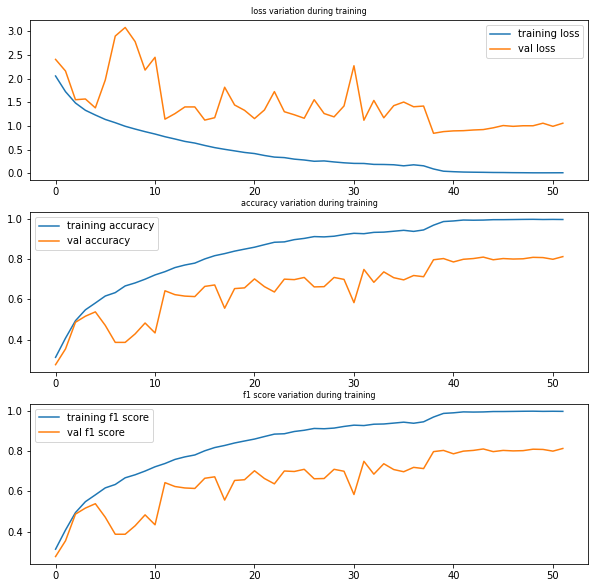

In [ ]:
#Plotting
exp_2.plot()

In [ ]:
exp_2.load_parameters("/content/model_densenet121_ 0.81.pth")

In [ ]:
exp_2.validate(validation_loader)

  0%|          | 0/26 [00:00<?, ?it/s]

(1.0102139, 0.8088942307692307, 0.8088942307692306)

  0%|          | 0/26 [00:00<?, ?it/s]

f1 score :  0.7788461538461539
              precision    recall  f1-score   support

    big_cats       0.92      0.98      0.95        87
   butterfly       0.90      0.79      0.84        66
         cat       0.77      0.57      0.65        53
     chicken       0.78      0.79      0.78        99
         cow       0.60      0.63      0.62        52
         dog       0.72      0.75      0.73       121
    elephant       0.72      0.81      0.76        42
        goat       0.69      0.64      0.67        59
       horse       0.73      0.76      0.75        79
      spider       0.90      0.88      0.89       130
    squirrel       0.66      0.75      0.70        44

    accuracy                           0.78       832
   macro avg       0.76      0.76      0.76       832
weighted avg       0.78      0.78      0.78       832



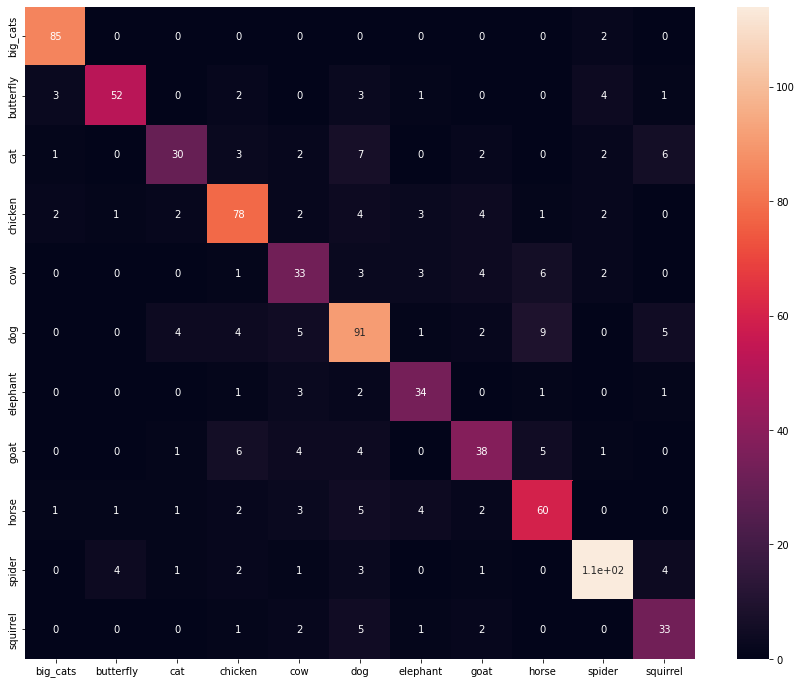

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_val)
y_hat = exp_2.predict_loader(test_loader)
y_true = dataset.labels[test_dataset.indices]
print("f1 score : ",f1_score(y_hat,y_true, average='micro'))
print(classification_report(y_true, y_hat,target_names=list(class_dic.keys())))

M = confusion_matrix(y_true, y_hat)

df_cm = pd.DataFrame(M, index = [i for i in list(class_dic.keys())],
                      columns = [i for i in list(class_dic.keys())])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)

In [ ]:
t = transforms.Compose([transforms.Resize(input_size),transforms.ToTensor()])

params['TEST'] = True
dataset_test =Dataset(params,transform = t)
test_loader_submission = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=128)
y_test_hat = exp_2.predict_loader(test_loader_submission)

sub = pd.DataFrame()
sub['id'] = np.arange(17831)
sub['class'] = y_test_hat
sub.to_csv("DENSENET_81.csv",index=False)
sub.head(20)

  0%|          | 0/140 [00:00<?, ?it/s]

,id,class
0,0,3
1,1,4
2,2,4
3,3,10
4,4,5
5,5,5
6,6,7
7,7,5
8,8,9
9,9,4


##5. Training the Resnet18 model using log softmax activation function :

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn1 = models.resnet18(pretrained=False)
        self.cnn1.fc = nn.Linear(512, 11)
      
    def forward(self, x):
        out =self.cnn1(x)
        return torch.log_softmax(out, dim=1)

model= CNN().cuda() #CNN()
exp_1 = Experiment(model)

for param in exp_1.model.parameters():
    param.requires_grad = True
#model.load_parameters("")

model

CNN(
  (cnn1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

We create three dataset objects, one for the training, one for the validation and on for testing.

In [ ]:
input_size = 224
t = transforms.Compose([transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(5),
                        transforms.RandomRotation(7),
                        transforms.Resize(input_size),
                        transforms.ToTensor()])


params = {}
params['VALIDATION_AND_TEST_SET_SIZE'] = 0.05
params['INPUT_SIZE'] = input_size
params['TEST'] = False
params['MODE'] = "ALL_ORIGINAL"

dataset =Dataset(params,transform= t)
train_dataset ,val_dataset, test_dataset  = dataset.split_data()

print('train size : ',len(train_dataset))
print('val size : ',len(val_dataset))
print('test size : ',len(test_dataset))

train size :  10699
val size :  594
test size :  594


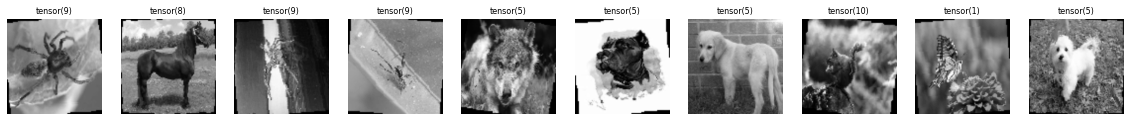

In [ ]:
import matplotlib.pyplot as plt
import random 
W_grid = 10
L_grid = 1

fig, axes = plt.subplots(L_grid, W_grid, figsize = (20,5))


for i in range(W_grid):
  index = random.randint(0,len(dataset) ) 
  image = dataset[index][0].numpy()
  axes[i].imshow(image[0], cmap='gray')

  axes[i].set_title(dataset[index][1], fontsize = 8)
  axes[i].axis('off')



In [ ]:

## Creating 
batch_size_train = 128
batch_size_val = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train)
validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size_val)

In [ ]:
exp_1.train(train_data_loader=train_loader,
                        val_data_loader=validation_loader,
                        save_dir="/content/",
                        model_name = 'model resnet18',
                        num_epochs=100,
                        learning_rate=0.001, 
                        validate_each_epoch=True,
                        verbose=True)


Epoch 1/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  3.1449056  Val Acc :  0.18686868686868688  Val f1 :  0.18686868686868688
Epoch 2/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  8.303004  Val Acc :  0.12626262626262627  Val f1 :  0.12626262626262627
Epoch 3/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  2.9319394  Val Acc :  0.3164983164983165  Val f1 :  0.3164983164983165
Epoch 4/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  4.565349  Val Acc :  0.20202020202020202  Val f1 :  0.20202020202020202
Epoch 5/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  2.346702  Val Acc :  0.3265993265993266  Val f1 :  0.3265993265993266
Epoch 6/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  3.3595498  Val Acc :  0.28619528619528617  Val f1 :  0.28619528619528617
Epoch 7/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  3.5223377  Val Acc :  0.32323232323232326  Val f1 :  0.32323232323232326
Epoch 8/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.2256839  Val Acc :  0.6212121212121212  Val f1 :  0.6212121212121212
Epoch 9/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.0653074  Val Acc :  0.6548821548821548  Val f1 :  0.6548821548821548
Epoch 10/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  5.961079  Val Acc :  0.2239057239057239  Val f1 :  0.2239057239057239
Epoch 11/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.6083524  Val Acc :  0.5084175084175084  Val f1 :  0.5084175084175084
Epoch 12/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.8926003  Val Acc :  0.4831649831649832  Val f1 :  0.4831649831649832
Epoch 13/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  3.3099294  Val Acc :  0.3383838383838384  Val f1 :  0.3383838383838384
Epoch 14/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.208831  Val Acc :  0.6279461279461279  Val f1 :  0.6279461279461279
Epoch 15/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  3.0075154  Val Acc :  0.38215488215488214  Val f1 :  0.38215488215488214
Epoch 16/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  2.2177787  Val Acc :  0.4797979797979798  Val f1 :  0.4797979797979798
Epoch 17/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.6724405  Val Acc :  0.569023569023569  Val f1 :  0.569023569023569
Epoch 18/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.8090773  Val Acc :  0.5353535353535354  Val f1 :  0.5353535353535354
Epoch 19/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  3.6996818  Val Acc :  0.3686868686868687  Val f1 :  0.36868686868686873
Epoch 20/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  2.2508268  Val Acc :  0.5134680134680135  Val f1 :  0.5134680134680135
Epoch 21/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.2691597  Val Acc :  0.6801346801346801  Val f1 :  0.6801346801346801
Epoch 22/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.8039347  Val Acc :  0.5892255892255892  Val f1 :  0.5892255892255892
Epoch 23/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  5.0763288  Val Acc :  0.39057239057239057  Val f1 :  0.39057239057239057
Epoch 24/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.456125  Val Acc :  0.6464646464646465  Val f1 :  0.6464646464646465
Epoch 25/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  2.3514035  Val Acc :  0.531986531986532  Val f1 :  0.531986531986532
Epoch 26/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.3145872  Val Acc :  0.6734006734006734  Val f1 :  0.6734006734006734
Epoch 27/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.4325217  Val Acc :  0.6178451178451179  Val f1 :  0.6178451178451179
Epoch 28/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.7932281  Val Acc :  0.6060606060606061  Val f1 :  0.6060606060606061
Epoch 29/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.1325915  Val Acc :  0.7356902356902357  Val f1 :  0.7356902356902357
Epoch 30/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.6160214  Val Acc :  0.6464646464646465  Val f1 :  0.6464646464646465
Epoch 31/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.307172  Val Acc :  0.7289562289562289  Val f1 :  0.7289562289562289
Epoch 32/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  2.9340723  Val Acc :  0.5218855218855218  Val f1 :  0.5218855218855218
Epoch 33/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  2.0119886  Val Acc :  0.6296296296296297  Val f1 :  0.6296296296296297
Epoch 34/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.3253721  Val Acc :  0.7171717171717171  Val f1 :  0.7171717171717171
Epoch 35/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.8520082  Val Acc :  0.6279461279461279  Val f1 :  0.6279461279461279
Epoch 36/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  1.6552725  Val Acc :  0.6734006734006734  Val f1 :  0.6734006734006734
Epoch    36: reducing learning rate of group 0 to 1.0000e-04.
Epoch 37/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8707663  Val Acc :  0.803030303030303  Val f1 :  0.803030303030303
Epoch 38/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8554393  Val Acc :  0.8080808080808081  Val f1 :  0.8080808080808081
Epoch 39/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.90707207  Val Acc :  0.7962962962962963  Val f1 :  0.7962962962962963
Epoch 40/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8699895  Val Acc :  0.7946127946127947  Val f1 :  0.7946127946127947
Epoch 41/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.84080476  Val Acc :  0.8080808080808081  Val f1 :  0.8080808080808081
Epoch 42/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8723035  Val Acc :  0.8013468013468014  Val f1 :  0.8013468013468014
Epoch 43/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8499953  Val Acc :  0.803030303030303  Val f1 :  0.803030303030303
Epoch 44/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8482114  Val Acc :  0.8097643097643098  Val f1 :  0.8097643097643098
Epoch 45/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.78659886  Val Acc :  0.8164983164983165  Val f1 :  0.8164983164983165
Epoch    45: reducing learning rate of group 0 to 1.0000e-05.
Epoch 46/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8387812  Val Acc :  0.8063973063973064  Val f1 :  0.8063973063973064
Epoch 47/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8397316  Val Acc :  0.8097643097643098  Val f1 :  0.8097643097643098
Epoch 48/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8212654  Val Acc :  0.8097643097643098  Val f1 :  0.8097643097643098
Epoch 49/100


  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Val loss :  0.8884344  Val Acc :  0.8013468013468014  Val f1 :  0.8013468013468014
Epoch    49: reducing learning rate of group 0 to 1.0000e-06.
Epoch 50/100


  0%|          | 0/84 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

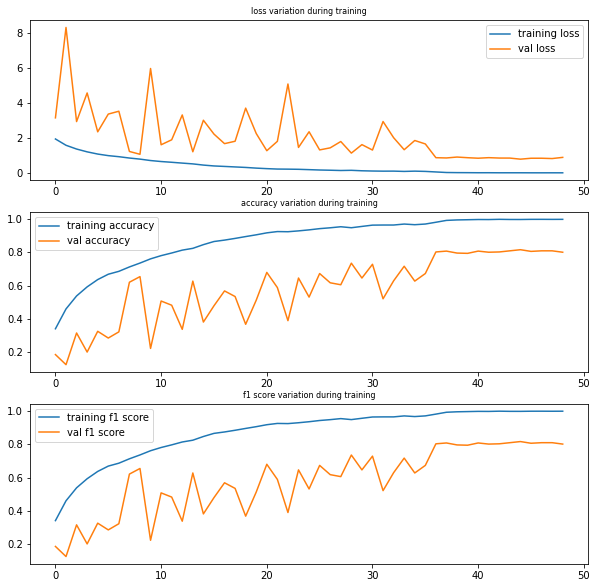

In [ ]:
exp_1.plot()

In [ ]:
exp_1.load_parameters("/content/model resnet18 0.82.pth")

In [ ]:
exp_1.validate(validation_loader)

  0%|          | 0/5 [00:00<?, ?it/s]

(0.8735689, 0.8114478114478114, 0.8114478114478115)

  0%|          | 0/5 [00:00<?, ?it/s]

f1 score :  0.8013468013468014
              precision    recall  f1-score   support

    big_cats       0.95      0.94      0.94        63
   butterfly       0.79      0.85      0.81        52
         cat       0.86      0.65      0.74        37
     chicken       0.80      0.86      0.83        73
         cow       0.70      0.72      0.71        32
         dog       0.76      0.82      0.79        96
    elephant       0.82      0.82      0.82        28
        goat       0.74      0.64      0.69        36
       horse       0.78      0.78      0.78        50
      spider       0.84      0.82      0.83        98
    squirrel       0.68      0.66      0.67        29

    accuracy                           0.80       594
   macro avg       0.79      0.78      0.78       594
weighted avg       0.80      0.80      0.80       594



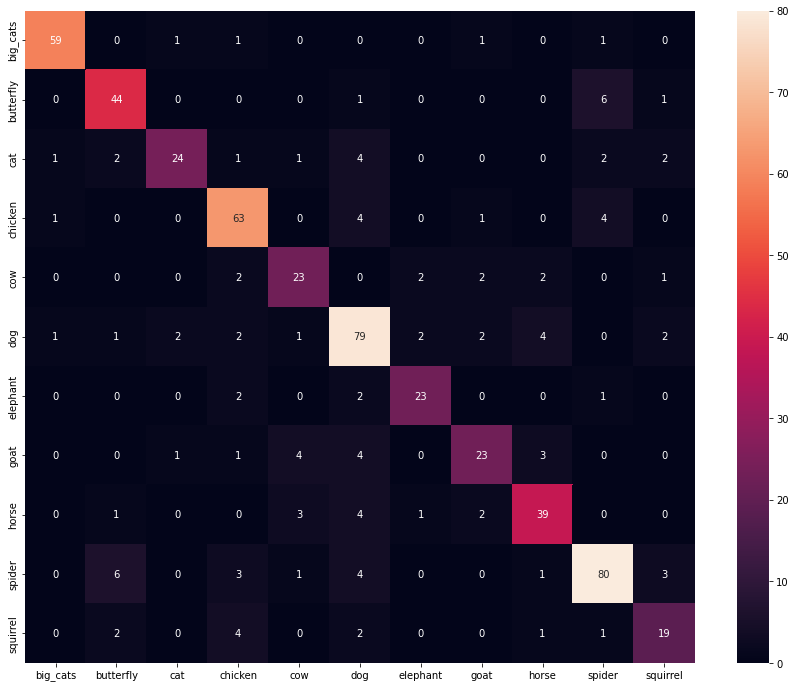

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_val)
y_hat = exp_1.predict_loader(test_loader)
y_true = dataset.labels[test_dataset.indices]
print("f1 score : ",f1_score(y_hat,y_true, average='micro'))
print(classification_report(y_true, y_hat,target_names=list(class_dic.keys())))

M = confusion_matrix(y_true, y_hat)

df_cm = pd.DataFrame(M, index = [i for i in list(class_dic.keys())],
                      columns = [i for i in list(class_dic.keys())])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)

In [ ]:
t = transforms.Compose([transforms.Resize(input_size),transforms.ToTensor()])

params['TEST'] = True
dataset_test =Dataset(params,transform = t)
test_loader_submission = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=128)
y_test_hat = exp_1.predict_loader(test_loader_submission)


sub = pd.DataFrame()
sub['id'] = np.arange(17831)
sub['class'] = y_test_hat
sub.to_csv("RESNET_3_log_softmax_82.csv",index=False)
sub.head(20)

  0%|          | 0/140 [00:00<?, ?it/s]

,id,class
0,0,3
1,1,8
2,2,4
3,3,10
4,4,5
5,5,5
6,6,7
7,7,5
8,8,9
9,9,4


##6. Using Resnet for Feature extraction + Random Forest for classification 

In [ ]:
X_train = np.array(exp.feature_extraction(train_loader))
Y_train = dataset.labels[train_dataset.indices]

In [ ]:
Y_train.shape

(10223,)

In [ ]:
X_val_features = np.array(exp.feature_extraction(validation_loader))
X_test_features = np.array(exp.feature_extraction(test_loader))

Y_val = np.concatenate([dataset.labels[val_dataset.indices],dataset.labels[test_dataset.indices]])
X_val = np.concatenate([X_val_features,X_test_features])

print(X_val.shape)
print(y_val.shape)

(1664, 512)
(1664,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict


f1_val_list = []
nb_estimator_list = range(1,200,50)
for i in nb_estimator_list:
  #create the classifier and tune the parameters (more on the documentations)
  rf = RandomForestClassifier(n_estimators= i)
  #fit the data
  rf.fit(X_train, Y_train)
  #make the prediction on the unseen data
  y_hat =rf.predict(X_val)
  f1 = f1_score(y_hat,y_val, average='macro')
  print("f1 score for validation: ",f1)
  f1_val_list.append(f1)

nb_estimator = nb_estimator_list[np.argmax(f1_val_list)]
rf = RandomForestClassifier(n_estimators= nb_estimator)
#fit the data
rf.fit(X_train, Y_train)
#make the prediction on the unseen data
y_hat =rf.predict(X_val)

print("f1 score for train: ",f1_score(rf.predict(X_train),Y_train, average='macro'))
print("f1 score for validation: ",f1_score(y_hat,Y_val, average='macro'))
print(classification_report(Y_val, y_hat,target_names=list(class_dic.keys())))

M = confusion_matrix(Y_val, y_hat)

df_cm = pd.DataFrame(M, index = [i for i in list(class_dic.keys())],
                      columns = [i for i in list(class_dic.keys())])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)


f1 score for train:  0.9956420198318814
f1 score for validation:  0.7873762946965094
              precision    recall  f1-score   support

    big_cats       0.95      0.95      0.95       170
   butterfly       0.86      0.77      0.81       120
         cat       0.77      0.66      0.71       121
     chicken       0.74      0.76      0.75       168
         cow       0.67      0.71      0.69        94
         dog       0.73      0.81      0.77       259
    elephant       0.89      0.74      0.81        78
        goat       0.70      0.72      0.71       101
       horse       0.82      0.77      0.79       147
      spider       0.87      0.92      0.90       289
    squirrel       0.80      0.74      0.77       117

    accuracy                           0.80      1664
   macro avg       0.80      0.78      0.79      1664
weighted avg       0.81      0.80      0.80      1664



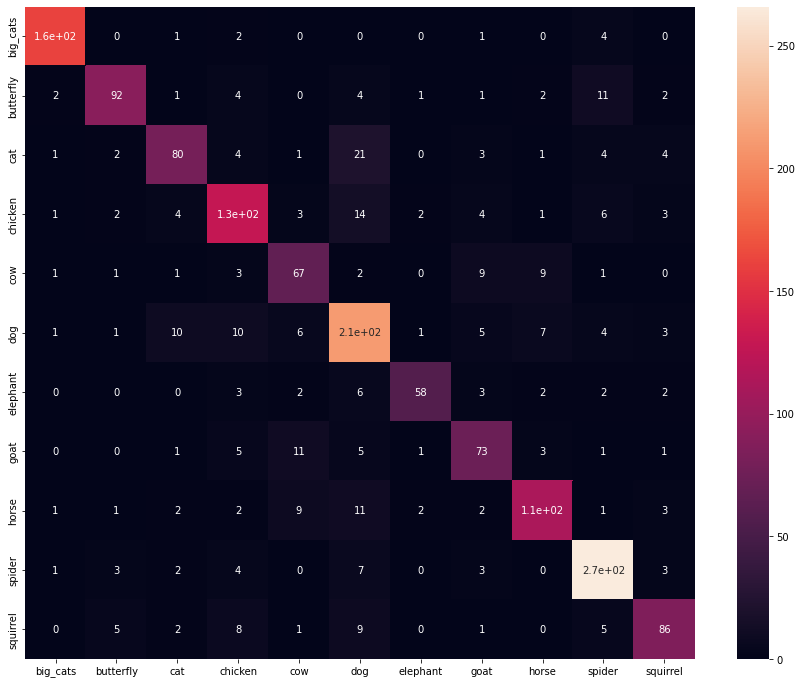

In [ ]:
#importing svm
from sklearn import svm

## initializing svm classifier (svc)
svm_clf = svm.SVC()

## training the model#fit the data
svm_clf.fit(X_train, Y_train)
#make the prediction on the unseen data
y_hat =svm_clf.predict(X_val)

print("f1 score for train: ",f1_score(svm_clf.predict(X_train),Y_train, average='macro'))
print("f1 score for validation: ",f1_score(y_hat,Y_val, average='macro'))
print(classification_report(Y_val, y_hat,target_names=list(class_dic.keys())))

M = confusion_matrix(Y_val, y_hat)

df_cm = pd.DataFrame(M, index = [i for i in list(class_dic.keys())],
                      columns = [i for i in list(class_dic.keys())])
plt.figure(figsize = (15,12))
sn.heatmap(df_cm, annot=True)

Submit 

In [ ]:
t = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])

params['TEST'] = True
dataset_test =Dataset(params,transform = t)
test_loader_submission = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=512)
test_inputs = np.array(exp.predict_loader(test_loader_submission,False))

y_test_hat =rf.predict(test_inputs)

sub = pd.DataFrame()
sub['id'] = np.arange(17831)
sub['class'] =y_test_hat
sub.to_csv("sub_96.csv",index=False)
sub.head(20)

  0%|          | 0/35 [00:00<?, ?it/s]

,id,class
0,0,3
1,1,8
2,2,4
3,3,10
4,4,5
5,5,4
6,6,7
7,7,8
8,8,9
9,9,4


##7. Majority Vote

In [ ]:
#majority vote :

from scipy.stats import mode

sub1 = pd.read_csv("/content/RESNET_3_log_softmax_82.csv")['class'].values
sub2 = pd.read_csv("/content/sub_82_RESNET_ALL_ORIGINAL.csv")['class'].values
sub3 = pd.read_csv("/content/RESNET_81 (1).csv")['class'].values
sub4 = pd.read_csv("/content/DENSENET_81.csv")['class'].values

sub_stack = np.stack([sub1,sub2,sub3,sub4],axis = 0)
y_test_hat = mode(sub_stack, axis=0)[0][0]
print(len(y_test_hat))



sub = pd.DataFrame()
sub['id'] = np.arange(17831)
sub['class'] = y_test_hat
sub.to_csv("sub_majority_vote_2_res_1_res_log_1_dens_.csv",index=False)
sub.head(20)

17831


,id,class
0,0,3
1,1,8
2,2,4
3,3,10
4,4,5
5,5,5
6,6,7
7,7,5
8,8,9
9,9,4


In [ ]:
!kaggle competitions submit -c fall2021-inf8245e-machine-learning -f /content/sub_majority_vote_3.csv -m "Message"

100% 129k/129k [00:01<00:00, 90.2kB/s]
Successfully submitted to Fall2021 -INF8245E - Machine Learning